# Sentence Completion
This notebook is used for a final project as a part of the CS 4980 Natural Language Processing course at the Milwaukee School of Engineering during the spring term of 2023. This notebook was created by [Grant Fass](grantfass@gmail.com) and [Nicholas Kaja](kajan@msoe.edu). The following notebook will explore the problem of natural language sentence completion. This notebook can also be reached directly through the following GitHub repository: [https://github.com/GrantFass/NLP/tree/main/Sentence%20Completion](https://github.com/GrantFass/NLP/tree/main/Sentence%20Completion)

Natural language sentence completion involves determining what word best fits in a blank present in a sentence. This type of question is typically found on the Scholastic Aptitude Test (SAT). It is useful because it can measure the performance of a language model (LM) on questions that educational experts deem important. LMs that perform well on this type of problem will likely perform better on broader tasks.

The primary method for forming a sentence completion model is to compute the probability of each possible sentence tehn choose the most probable option. This probability computation can be done using n-grams, Latent Semantic Analysis (LSA), and Syntactic Dependency Trees. Some research has also been done into combining these with methods of preserving long-range dependencies in the sentences. Of these options, N-grams is one of the easiest starting points due to its ease of implementation and understanding. N-grams also allow for sufficient variations over the base model such as different N-gram algorithms, different values of N, and different methods of tokenization.

We will be constructing our models from a dataset of Khan Academy lecture transcripts. This dataset was scraped using BeautifulSoup during January of 2023 by Nicholas Kaja as a part of a senior design project. The performance of our model will be evaluated on a [SAT Question Dataset](https://github.com/ctr4si/sentence-completion/tree/master/data/completion). After evaluation, we plan to take our best performing model and apply it to sentence generation. This will allow us to get a better feel for how well it performs. Once our model is working, we also plan to implement some additional features such as Named Entity Recognition (NER). If there is enough time we also plan to investigate using the [OpenAI tokenizer](https://platform.openai.com/tokenizer) instead of the [NLTK Word Tokenizer](https://www.nltk.org/api/nltk.tokenize.html) or the [SpaCy Tokenizer](https://spacy.io/api/tokenizer). The OpenAI tokenizer has a [python package found on github](https://github.com/openai/tiktoken).

For more information please see the Data Collection And Processing document as well as the Project Background document. Both of these documents can be found in the repository under the Sentence Completion directory.

## Project Demo:
Note that this file is mainly used for training and testing the model we build. It also includes the explanations of processes. To view an interactive demo please visit the website located at [grantfass.org](http://grantfass.org).

## Pip Installations
The below magic command should install all of the required python packages to run this project. If it does not run successfully please try to run the command through an admin shell instead.

In [1]:
%pip install -r requirements.txt --user

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## Imports
This cell contains the imports and some setup functions. This is mostly generalized which means there are extra imports as of now.

In [2]:
from pathlib import Path
from collections import Counter, defaultdict
import pandas as pd
import random
from tqdm.notebook import tqdm
import nltk
from nltk.util import ngrams
import nltk.data
import re
import contractions
from bs4 import BeautifulSoup
import unidecode
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score
from sklearn.metrics import f1_score, recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer
import math
import numpy as np
import copy
import seaborn as sns
import matplotlib.pyplot as plt
import json
import pickle
from nltk.lm.preprocessing import flatten
from nltk.lm.preprocessing import padded_everygram_pipeline
from nltk.lm.preprocessing import pad_both_ends
from nltk.util import pad_sequence
from nltk.util import everygrams
from nltk.lm import MLE, KneserNeyInterpolated, Laplace, AbsoluteDiscountingInterpolated
from functools import partial

nltk.download([
"names",
"stopwords",
"state_union",
"twitter_samples",
"movie_reviews",
"averaged_perceptron_tagger",
"vader_lexicon",
"punkt",
])

lemmatizer = WordNetLemmatizer()
sia = SentimentIntensityAnalyzer()
encoder = LabelEncoder()
sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')
tqdm.pandas()
n = 3

[nltk_data] Downloading package names to
[nltk_data]     C:\Users\Grant\AppData\Roaming\nltk_data...
[nltk_data]   Package names is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Grant\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package state_union to
[nltk_data]     C:\Users\Grant\AppData\Roaming\nltk_data...
[nltk_data]   Package state_union is already up-to-date!
[nltk_data] Downloading package twitter_samples to
[nltk_data]     C:\Users\Grant\AppData\Roaming\nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\Grant\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Grant\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up

## Data Loading  
This section is used to load in all of the training data for the vocabulary. This comes from the 5 csv files of Khan Academy lectures. These files are all combined into a single dataframe for easier use and analysis. In the future we may need to include other sources of data such as ted talks or even ebooks in order to widen our vocabulary.

We also load in the SAT dataset here. This is a short dataset that we are primarily using as our testing set. The goal here is to guess which response option, out of five, is the correct response for a fill-in-the-blank SAT question. 

In [3]:
computing_df = pd.read_csv(Path("Datasets/KhanAcademy/Computing.csv"))
computing_df = computing_df.dropna()

economics_df = pd.read_csv(Path("Datasets/KhanAcademy/Economics.csv"))
economics_df = economics_df.dropna()

humanities_df = pd.read_csv(Path("Datasets/KhanAcademy/Humanities.csv"))
humanities_df = humanities_df.dropna()

math_df = pd.read_csv(Path("Datasets/KhanAcademy/Math.csv"))
math_df = math_df.dropna()

science_df = pd.read_csv(Path("Datasets/KhanAcademy/Science.csv"))
science_df = science_df.dropna()

khan_dfs = [computing_df, economics_df, humanities_df, math_df, science_df]
khan = pd.concat(khan_dfs, axis=0)
khan.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8261 entries, 0 to 2789
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   course       8261 non-null   object
 1   unit         8261 non-null   object
 2   lesson       8261 non-null   object
 3   video_title  8261 non-null   object
 4   about        8261 non-null   object
 5   transcript   8261 non-null   object
dtypes: object(6)
memory usage: 451.8+ KB


In [4]:
sat = pd.read_csv(Path("Datasets/SAT_Question_Dataset.csv"))
sat.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152 entries, 0 to 151
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        152 non-null    int64 
 1   ans       152 non-null    object
 2   question  152 non-null    object
 3   a)        152 non-null    object
 4   b)        152 non-null    object
 5   c)        152 non-null    object
 6   d)        152 non-null    object
 7   e)        152 non-null    object
 8   year      152 non-null    int64 
 9   sec       152 non-null    int64 
 10  num       152 non-null    int64 
 11  diff      152 non-null    object
 12  blanks    152 non-null    int64 
dtypes: int64(5), object(8)
memory usage: 15.6+ KB


## Cleaning
This section is dedicated to cleaning up some of our vocabulary dataset before it is used to create the vocabulary. We have decided, for simplicity, to remove the first sentence of every transcript in the dataset. This will allow us to easily remove all of the tagging information such as "[Instructor]" and "- Speaker 1:". Most of the first sentences are greetings and introductions. As such they are not necessarily as important to answering the SAT question dataset. We have also elected to expand contractions, remove html tags, remove quotes, and replace accented characters.

The same general cleaning method is run over our testing data as well. The first sentence removal is not performed on the testing data.

[Note] Before this section, as a part of the cleaning, we will want to perform SpaCy NER. Use SpaCy NER to identify the multi-word-expressions then use the [nltk.tokenize.mwe module](https://www.nltk.org/api/nltk.tokenize.mwe.html) to combine the tokens - Grant.

In [5]:
def clean_base(x: str):
        # remove any html tags
        x = BeautifulSoup(x, "html.parser").get_text(separator=" ")
        # # set all to lower
        # x = x.lower()
        # clean up the contractions
        x = contractions.fix(x)
        # remove accended characters
        x = unidecode.unidecode(x)
        # # remove stopwords: https://stackoverflow.com/questions/19560498/faster-way-to-remove-stop-words-in-python
        # x = ' '.join([word for word in x.split() if word not in cachedStopWords]) # slower to use word tokenize
        # # fix punctuation spacing
        # x = re.sub(r'(?<=[\.\,\?])(?=[^\s])', r' ', x)
        # # strip punctuation
        # x = re.sub(r'[\.\,\?\\\/\<\>\;\:\[\]\{\}]', r'', x)
        # strip quotes
        # x = x.replace('\'', '').replace('\"', '')
        x = x.replace('\"', '')
        # # remove some actions
        # remove_list = ['(Laughter)', '(laughter)', '(Music)', '(music)', '(Music ends)', '(Audience cheers)', '(Applause)', '(Applause ends)', '(Applause continues)', '(Bells)', '(Trumpet)', '(Clears throat)']
        # x = ' '.join([word for word in x.split() if word not in remove_list])
        # remove extraneous items
        x = x.replace(' -- ', '').replace(' .. ', ' ').replace(' ... ', ' ')
        # remove extra whitespace
        x = ' '.join(x.strip().split())
        # # may want to add lematization
        # x = ' '.join([lemmatizer.lemmatize(word) for word in x.split()])
        # remove some of the extra bracket tags
        x = re.sub(r"\s{2,}", " ", re.sub(r"[\(\[\{][^\)\]\}]*[\)\]\}]", "", x))
        return x

def remove_first_sentence(doc):
    """
    This removes the first sentence of a document. We use this to remove all narrator / speaker tags, and
    to remove unnecessary introductory sentences that most transcripts have
    """
    return ' '.join(nltk.sent_tokenize(doc)[1:])

transcripts = khan['transcript']
# transcripts = transcripts.progress_apply(remove_first_sentence)
transcripts = transcripts.progress_apply(clean_base)
khan['clean_transcript'] = transcripts
khan.head()


  0%|          | 0/8261 [00:00<?, ?it/s]

,course,unit,lesson,video_title,about,transcript,clean_transcript
0,Computer programming,Intro to JS: Drawing & Animation,Intro to programming,What is Programming?,Programming is the process of creating a set o...,"Hi, welcome to programming! If you've never le...","Hi, welcome to programming! If you have never ..."
1,Computer programming,Intro to JS: Drawing & Animation,Coloring,The Power of the Docs,Created by Pamela Fox.,Voiceover: Ok so you've\r\nmade a few programs...,"Voiceover: Ok so you have made a few programs,..."
5,Computer programming,Intro to HTML/CSS: Making webpages,Further learning,HTML validation,Learn how to validate your webpages with the W...,"- [Voiceover] On Khan Academy, we pop up the o...","- On Khan Academy, we pop up the oh noes guide..."
6,Computer programming,Intro to SQL: Querying and managing data,SQL basics,Welcome to SQL,SQL is useful for creating and querying relati...,- [Instructor] The world is full of data. Ever...,- The world is full of data. Every app that yo...
7,Computer programming,Intro to SQL: Querying and managing data,SQL basics,S-Q-L or SEQUEL?,How is it pronounced? Why? Let's discuss...,"At this point, you've probably heard me\r\npro...","At this point, you have probably heard me pron..."


In [6]:
for column_name in ['question', 'a)', 'b)', 'c)', 'd)', 'e)']:
    sat[column_name] = sat[column_name].progress_apply(clean_base)
sat.head()

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

,id,ans,question,a),b),c),d),e),year,sec,num,diff,blanks
0,1,e,Much of our knowledge of dinosaurs comes from ...,Much of our knowledge of dinosaurs comes from ...,Much of our knowledge of dinosaurs comes from ...,Much of our knowledge of dinosaurs comes from ...,Much of our knowledge of dinosaurs comes from ...,Much of our knowledge of dinosaurs comes from ...,2001,1,1,1,2
1,2,c,Responding to criticism that the script was ra...,Responding to criticism that the script was ra...,Responding to criticism that the script was ra...,Responding to criticism that the script was ra...,Responding to criticism that the script was ra...,Responding to criticism that the script was ra...,2001,1,2,1,2
2,3,e,Vernal pools are among the most _____ of ponds...,Vernal pools are among the most transitory of ...,Vernal pools are among the most anachronistic ...,Vernal pools are among the most immutable of p...,Vernal pools are among the most itinerant of p...,Vernal pools are among the most ephemeral of p...,2001,1,3,2,2
3,4,e,"During the 1990's, Shanghai benefited from an ...","During the 1990's, Shanghai benefited from an ...","During the 1990's, Shanghai benefited from an ...","During the 1990's, Shanghai benefited from an ...","During the 1990's, Shanghai benefited from an ...","During the 1990's, Shanghai benefited from an ...",2001,1,4,3,1
4,5,b,Many subatomic nuclear particles are _____ and...,Many subatomic nuclear particles are unstable ...,Many subatomic nuclear particles are elusive a...,Many subatomic nuclear particles are minute an...,Many subatomic nuclear particles are charged a...,Many subatomic nuclear particles are tenuous a...,2001,1,5,3,2


## N-Grams
This section is used for the tokenization of our text into N-Grams. Various tokenization approaches may yield different results. As such, it is important to test different approaches here. We begin by dividing each of the transcripts into its constituent sentences. These sentences are then each tokenized using the word tokenizer provided by nltk. A start and end of sentence tag is then added to each list of tokens. Next, these tokens are used to generate all possible n-grams below a certain size threshold. Lastly, we create a frequency distribution dictionary for the n-grams.

In [7]:
def tokenize_document(document):
    return [word_tokenize(t) for t in sent_detector.tokenize(document)]

def tokenize_documents(documents):
    sents = []
    for doc in tqdm(documents):
        for sent in tokenize_document(doc):
            sents.append(sent)
    return sents

def pad_sentence(tokens):
    return pad_both_ends(tokens, n=2)

def pad_sentences(sents):
    return [pad_sentence(sent) for sent in sents]

def custom_padded_everygam_pipeline(n, tokenized_sents):
    # these few lines come directly from the padded_everygram_pipeline source code
    padding_fn = partial(pad_both_ends, n=2)
    return (
        (everygrams(list(padding_fn(sent)), max_len=n) for sent in tokenized_sents),
        flatten(map(padding_fn, tokenized_sents)),
    )

print("Tokenizing Documents...")
sents = tokenize_documents(khan['clean_transcript'])
print("Building Custom Everygram Pipeline...")
train, vocab = custom_padded_everygam_pipeline(n, sents)
lm = MLE(n)
# lm = Laplace(n)
print("Fitting Language Model...")
lm.fit(train, vocab)
print(lm.vocab)


Tokenizing Documents...


  0%|          | 0/8261 [00:00<?, ?it/s]

Building Custom Everygram Pipeline...
Fitting Language Model...
<Vocabulary with cutoff=1 unk_label='<UNK>' and 58932 items>


## Store Model
The next step is to store the freq_dist model for use in future prediction methods.

In [8]:
def to_pickle(filename, model):
    with open(filename, 'wb') as fp:
        pickle.dump(model, fp)
        print("Saved %s" % (filename))
        
def from_pickle(filename):
    model = []
    with open(filename, 'rb') as fp:
        model = pickle.load(fp)
    return model

        
to_pickle(filename='lm.pkl', model=lm)

Saved lm.pkl


## SAT Dataset
This section focuses on the processing of individual SAT questions as well as defining a prediction method for the dataset. Below is a sample approach for the prediction method.

### SAT Question Prediction Approach
Note that this approach is slightly different from what was implemented. One of the main differences is that our tokenization currently includes punctuation as its own token whereas the below example removes punctuation.

"""  
Question:  
Responding to criticism that the script was rambling and _____, the new screenwriter revised the dialogue for greater succinctness and _____.

Possible Solutions:  
[('engaging', 'simplicity'), ('subjective', 'abiguity'), ('muddled', 'clarity'), ('terse', 'emptiness'), ('difficult', 'abstraction')]  
"""

N-gram size of 4 max
1. Change the blanks out to something we can use to mask the individual ones later. For example, [BLANK1] and [BLANK2].
    - esponding to criticism that the script was rambling and [BLANK1], the new screenwriter revised the dialogue for greater succinctness and [BLANK2].<\sent>
2. Pull out the possible sliding windows centered around each blank.
    - blank 1
        - n=4
            - ('was', 'rambling', 'and', [BLANK1])
            - ('rambling', 'and', [BLANK1], 'the')
            - ('and', [BLANK1], 'the', 'new')
            - ([BLANK1], 'the', 'new', 'screenwriter')
        - n=3
            - ('rambling', 'and', [BLANK1])
            - ('and', [BLANK1], 'the')
            - ([BLANK1], 'the', 'new')
        - n=2
            - ('and', [BLANK1])
            - ([BLANK1], 'the')
        - n=1
            - ([BLANK1])
    - blank 2
        - n=4
            - ('greater', 'succinctness', 'and', [BLANK2])
            - ('succinctness', 'and', [BLANK2], <\sent>)
        - n=3
            - ('succinctness', 'and', [BLANK2])
            - ('and', [BLANK2], <\sent>)
        - n=2
            - ('and', [BLANK2])
            - ([BLANK2], <\sent>)
        - n=1
            - ([BLANK2])
3. For each of the possible solutions:
    1. For each of the windows:
        1. If the first or second word in the possible solution tuple is not in the vocab then discard it as a possible solution.
        2. Replace [BLANK1] with the first item in the possible solution tuple
        3. Replace [BLANK2] with the second item in the possible solution tuple
        4. Lookup each of the window n-grams against the stored n-grams and determine how many times it occured.
        5. What to do if the count for a n-gram is 0 for one word but not for another word?
        6. Calculate the probability of each window n-gram
        7. sum the logs of the probabilities of each window n-gram. 
    2. Determine which of the windows had the highest log likelihood and return the associated word tuple.

### Scoring Experimentation:
This section explains some of the experimentation with the various methods of scoring which prediction was the most accurate in the predict method. The baseline prediction worked by taking the log in base 10 of (the count of the ngram divided by the count of the one smaller ngram). The code for this is shown below. All scores reported in this section are f1-scores. The two datasets that were evaluated were the SAT question dataset (SAT) and the SC-Ques dataset (ESL). The basline performance was 0.155 for SAT and 0.209 for ESL. Out of the possible models it appears that the best prediction accuracy was attained when using lm.score with the Maximum Likelihood Estimator. The most optimal size for n is likely 3 or 4. Quadgrams have a slightly better score, but take longer to train. For testing purposes bigrams may be the best option.

```
ngram_size = len(new_window)
raw_count = freq_dist[tuple(new_window)] # TODO: what if we try to use an ensemble of models with different maximum n-gram sizes?
if raw_count > 0:
    prior_count = 1
    if ngram_size > 1:
        prior = new_window[0: len(new_window) - 1]
        prior_count = freq_dist[tuple(prior)]
    raw_prob = raw_count / prior_count
    log_prob = math.log10(raw_prob)
    print(log_prob)
    log_likelihood += log_prob
```

#### Bigrams:
- MLE + lm.score
    - SAT: 0.231
    - ESL: 0.312
- MLE + lm.logscore
    - SAT: 0.122
    - ESL: 
- Laplace + lm.score
    - SAT: 0.185
    - ESL: 0.268
- Laplace + lm.logscore
    - SAT: 0.191
    - ESL: 0.288
- KneserNeyInterpolated
    - Of note is that this model is incredibly impractical. It is so slow that it feels like the computer froze most of the time. It also only got a 0.158 on lm.logscore for the SAT dataset.
- AbsoluteDiscountingInterpolated
    - Similar speed, including training times, to the MLE. Got a 0.184 for SAT on lm.logscore

#### Trigrams:
- MLE + lm.score
    - SAT: 0.231
    - ESL: 0.330
    
#### Quadgrams:
- MLE + lm.score
    - SAT: 238
    - ESL: 335
- MLE + lm.logscore
    - SAT: 0.07
    - ESL: 
- Laplace + lm.score
    - SAT: 0.191
    - ESL: 0.271
- Laplace + lm.logscore
    - SAT: 0.203
    - ESL: 0.305

#### 7-grams:
- MLE + lm.score
    - SAT: 0.238
    - ESL: 0.336

In [9]:
def predict_2(row, lm,  mask="_____"):
    # tokenize the inbound question
    tokens = word_tokenize(row['question'])
    question = list(pad_both_ends(tokens, n=2))
    # determine where the mask is without knowing how many masks there are.
    # note that .index is O(n) so we may as well iterate through ourselves to be more verbose.
    mask_indices = []
    mask_count = 0
    for idx in range(len(question)):
        if question[idx] == mask:
            # store the index of the mask
            mask_indices.append(idx)
            # convert the mask to one with a number for future reference
            question[idx] = mask + str(mask_count)
            mask_count += 1
    # pull out the windows
    grams = list(everygrams(question, min_len=1, max_len=n))
    windows = []
    for i in range(len(mask_indices)):
        remask = mask + str(i)
        for gram in grams:
            if remask in gram:
                windows.append(gram)
    # extract the possible solutions
    if mask_indices:
        column_names = ['a)', 'b)', 'c)', 'd)', 'e)']
        solution_likelihoods = []
        for name in column_names:
            if name in row and isinstance(row[name], str) and row[name] != "":
                # tokenize the input
                tokens = word_tokenize(row[name])
                tokens = list(pad_both_ends(tokens, n=2))
                # calculate the probability
                log_likelihood = 0
                custom_windows = []
                for window in windows:
                    # # fill in the blanks in the windows with the possible solutions.
                    new_window = window
                    for i in range(len(mask_indices)):
                        remask = mask + str(i)
                        new_window = list(map(lambda x: x.replace(remask, tokens[mask_indices[i]]), new_window))
                    custom_windows.append(new_window)
                    log_likelihood += lm.score(new_window[-1], new_window[0:-1])
                solution_likelihoods.append((name, log_likelihood))
        solution_likelihoods.sort(key = lambda x: x[1], reverse = True)
        ans = solution_likelihoods[0][0]
        return ans.replace(")", "")
    
    
def score(y_true, y_pred):
    print("%-15s: %.3f" % ("[ACCURACY]", accuracy_score(y_true, y_pred)))
    print("%-15s: %.3f" % ("[PRECISION]", precision_score(y_true, y_pred, average='weighted')))
    print("%-15s: %.3f" % ("[RECALL]", recall_score(y_true, y_pred, average='weighted')))
    print("%-15s: %.3f" % ("[F1-SCORE]", f1_score(y_true, y_pred, average='weighted')))    
    
def record_model_metrics_as_json(y_true, y_pred):
    metrics = {}
    metrics['accuracy_score'] = accuracy_score(y_true, y_pred)
    metrics['precision_score'] = precision_score(y_true, y_pred, average='weighted')
    metrics['recall_score'] = recall_score(y_true, y_pred, average='weighted')
    metrics['f1_score'] = f1_score(y_true, y_pred, average='weighted')
    return metrics    

In [10]:
test = sat.iloc[1]
predict_2(test, lm)

'e'

## Predictions
This section is used to actually compute the predictions for our test data and our given input frequency distribution. The results of the prediction are then evaluated.

In [11]:
predictions = sat.progress_apply(lambda row: predict_2(row, lm), axis=1)
true_values = sat['ans']
sat_metrics = record_model_metrics_as_json(true_values, predictions)
sat_metrics

  0%|          | 0/152 [00:00<?, ?it/s]

{'accuracy_score': 0.23026315789473684,
 'precision_score': 0.2332570697482669,
 'recall_score': 0.23026315789473684,
 'f1_score': 0.231417998297417}

In [12]:
# conf = confusion_matrix(true_values, predictions)
# fig, ax = plt.subplots(figsize=(8,6), dpi=100)
# display = ConfusionMatrixDisplay(conf, display_labels=['a', 'b', 'c', 'd', 'e'])
# ax.set(title='Confusion Matrix for SAT sentence completion')
# display.plot(ax=ax)

## Evaluation of Results
Our model does not perform that well currently. We hypothesize that this is due to both the complexity of the words in the SAT question dataset as well as the size of our input dataset. Our input dataset is only comprised of around 600,000 sentences. Additionally, our input dataset comes from spoken lecture transcripts. While these transcripts should be on fairly complex topics, they still contain mostly spoken language. The SAT question dataset prompts are more complex than the language spoken in our input dataset. This leads to a mismatch between our corpus and training data where most of our n-grams either have low counts or do not exist in our corpus. This could be remedied by expanding the size of our input dataset and thusly our corpus. The research paper that our test dataset came from compiled their corpus on over 1.1 billion words in newspaper articles. Even with this large increase in corpus size they still only achieved a prediction accuracy of just over 50% on the testing dataset. This implies that the test dataset is fairly difficult to get high accuracy scores on.

Note that we did not perform cross validation on our system. The primary reason for this is due to cross validation not making sense in our case. We have created a corpus and are trying to compute the accuracy of our corpus using a test set. As we are not directly training a model, it does not make sense to perform cross validation only over our test set.

## Additionl Dataset Note
[Note] One additional area of improvement that we should also test is improving the size of our test set. I found another dataset that will work for this from the paper [SC-Ques: A Sentence Completion Question Dataset for English as a Second Language Learners](https://arxiv.org/abs/2206.12036). They provided a [link to their code and their data](https://github.com/ai4ed/SC-Ques) for research purposes. This, in turn, gave a link to a [dropbox containing their data](https://www.dropbox.com/s/lzznin2hxt6rmft/SC-Ques.tar.gz?dl=0). The data that we would be looking to use to expand our training set would be found in test.jsons and train.jsons. These two files have been preprocessed in the SC-Ques-Preprocessing.ipynb notebook and saved to the individual processed_data_idx.csv files. They were stored as multiple files due to space limitations with GitHub repositories.

The below section is used to read in and join each of the processed_data_idx.csv files. There should be no need to run the SC-Ques-Preprocessing.ipynb script and is only included for posterity.

In [13]:
directory_path = Path("Datasets/SC-Ques")
sc_ques = pd.DataFrame()
for data_path in directory_path.glob("**/processed_data_*.csv"):
    # print(data_path)
    data = pd.read_csv(data_path)
    sc_ques = pd.concat([sc_ques, data])
sc_ques = sc_ques.drop(columns=['Unnamed: 0'])
sc_ques

,question,ans,blanks,a),b),c),d),e)
0,The plane is scheduled to arrive _____ because...,c,1,The plane is scheduled to arrive latest becaus...,The plane is scheduled to arrive later because...,The plane is scheduled to arrive late because ...,NaN,NaN
1,_____ he was preparing food for tomorrow's pa...,b,1,Because he was preparing food for tomorrow's p...,While he was preparing food for tomorrow's par...,"If he was preparing food for tomorrow's party,...",NaN,NaN
2,I don't like the people _____ may get angry ea...,d,1,I don't like the people who may get angry easily.,I don't like the people that may get angry eas...,I don't like the people which may get angry ea...,I don't like the people both may get angry eas...,NaN
3,Stop making so much noise. It is _____ to the ...,c,1,Stop making so much noise. It is comfortable t...,Stop making so much noise. It is relaxed to th...,Stop making so much noise. It is harmful to th...,NaN,NaN
4,Charles Dickens _____ a lot of novels.,b,1,Charles Dickens write a lot of novels.,Charles Dickens wrote a lot of novels.,Charles Dickens writes a lot of novels.,NaN,NaN
...,...,...,...,...,...,...,...,...
14452,"If you keep _____ this, your English handwriti...",b,1,"If you keep do this, your English handwriting ...","If you keep doing this, your English handwriti...","If you keep to do this, your English handwriti...","If you keep does this, your English handwritin...",NaN
14453,"Two days later, the fighting between the two c...",c,1,"Two days later, the fighting between the two c...","Two days later, the fighting between the two c...","Two days later, the fighting between the two c...","Two days later, the fighting between the two c...",NaN
14454,What he had said about the incident and done w...,b,1,What he had said about the incident and done w...,What he had said about the incident and done w...,What he had said about the incident and done w...,What he had said about the incident and done w...,NaN
14455,"Get up quickly, Lisa! You have _____ time to h...",c,1,"Get up quickly, Lisa! You have a few time to h...","Get up quickly, Lisa! You have many time to ha...","Get up quickly, Lisa! You have no time to have...",NaN,NaN


In [14]:
test = sc_ques.iloc[89546]
print(test['question'])
print(test['a)'])
print(test['b)'])
print(test['c)'])
print(test['d)'])


—Do you often do some _____ in the morning? —Yes, I do morning _____ . 
—Do you often do some exercise in the morning? —Yes, I do morning exercise .
—Do you often do some exercises in the morning? —Yes, I do morning exercises .
—Do you often do some exercise in the morning? —Yes, I do morning exercises .
—Do you often do some exercises in the morning? —Yes, I do morning exercise .


In [15]:
# of note is that there is next to 0 f1-score difference for n=4 compared to n=3
predictions = sc_ques.progress_apply(lambda row: predict_2(row, lm), axis=1)
true_values = sc_ques['ans']
sc_ques_metrics = record_model_metrics_as_json(true_values, predictions)
sc_ques_metrics

  0%|          | 0/289148 [00:00<?, ?it/s]

{'accuracy_score': 0.3322865798829665,
 'precision_score': 0.339073921029823,
 'recall_score': 0.3322865798829665,
 'f1_score': 0.3301203008326494}

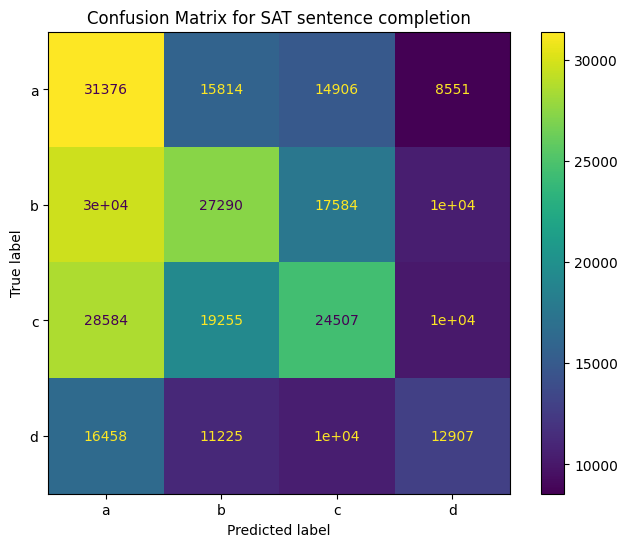

In [22]:
# conf = confusion_matrix(true_values, predictions)
# fig, ax = plt.subplots(figsize=(8,6), dpi=100)
# display = ConfusionMatrixDisplay(conf, display_labels=['a', 'b', 'c', 'd'])
# ax.set(title='Confusion Matrix for SAT sentence completion')
# display.plot(ax=ax)

## Store the most recent run of training metrics as a pickle file

In [17]:
metrics = {"sat": sat_metrics, "sc_ques": sc_ques_metrics}
to_pickle(filename="metrics.pkl", model=metrics)

Saved metrics.pkl


## TODO:
- write up the readme with dependencies
- write up a how to run
- write up how to use.
- pickle the model that we need. This notebook is only for training the model basically
- Need to write up a python script that allows us to load the model (from the git repo so nobody needs to download it) and will suppport sentence completion as well as sentence writing.
- do not want to need to download the csv's either.
- Needs to be by Wednesday.
- Play with removing punctuation during cleaning.
- number to word conversion (look at "ozone contains _____ oxygen atoms")

## Final Presentation
- aimed towards our peers
- need functioning copy of final project
- what it does and how we did it
- how we chose data
- what we did to the data
- how we trained the model
- give or take 10 min long including demonstration
- 12 groups.
- can switch to giving presentations during the last week of class.

## Sentence Generation
The below section takes a look at both sentence generation, as well as the optimization of some existing processes. Much of the work in this section is originally based on [a stack overflow post](https://stackoverflow.com/a/54979617) and [the Maximum Likelihood Estimator (MLE) documentation from NLTK](https://www.nltk.org/api/nltk.lm.html). The work in this section could be performed as one command if we were to use the padded_everygram_pipeline method. Unfortunatly, this method presents certain downsides when the n-gram size is larger than 2 (bigrams). This is because the sentences will be padded with more than one start of sentence or end of sentence tag. This leads to the model predicting the end of sentence tag following another end of sentence tag, thus causing an infinite loop.

Instead, we will perform these steps in parts. The first part would be to get a flattened list of tokens comprised of each padded sentence in our corpus. This can be done using the flatten and pad_both_ends commands. As mentioned earlier, even if the n-gram size is larger than two, a value of 2 should be passed in to pad_both_ends. Following this, we can calculate our n-grams using everygrams, or ngrams.

As per [this stackoverflow post](https://stackoverflow.com/a/60661188) the padded_everygram_pipeline creates the following iterators:
- sentences padded and turned into sequences of `nltk.util.everygrams`
- sentences padded as above and chained together for a flat stream of words

This information should help with passing arguments to the fit method of the MLE

In [18]:
# print(lm.vocab.lookup(sample_lecture_sentences[0]))
print(lm.counts)
print(lm.counts['a'])
print(lm.counts[['<s>']]['The'])
print(lm.score("a"))
print(lm.score("The", ["<s>"]))
print(lm.logscore("a"))
print(lm.logscore("The", ["<s>"]))


<NgramCounter with 3 ngram orders and 37386456 ngrams>
203630
19038
0.015575217177637253
0.031116842616246854
-6.004603909741127
-5.0061605103303455


In [19]:
' '.join(lm.generate(30, random_seed=3))

'I have drawn it like here , we can draw yet another two electrons in bonds and two kings . </s> . </s> lead storage battery as soon as you'

In [20]:
' '.join(lm.generate(30, text_seed=['a'], random_seed=3))

'discussion of how small some of competing selective factors . </s> from the last video , we understood what was the Oneida community . </s> , we get that the'

In [21]:
# look at generating text until it is satisfied
start_token = '<s>'
end_token = '</s>'
output = [start_token]
print("starting output sequence: %s" % str(output))
satisfaction_threshold_log = -15
satisfaction_threshold = 0
satisfaction = 0
count = 0
while satisfaction > satisfaction_threshold_log and count < 50:
    count += 1
    generated = lm.generate(1, text_seed=output) # , random_seed=3
    if isinstance(generated, str):
        generated = [generated]
    # print("generated sequence: %s" % str(generated))
    temp_output = output + generated
    # print("new output sequence: %s" % str(temp_output))
    prior_token = generated[-1]
    # print("new token: %s" % prior_token)
    # print("last token: %s" % temp_output[-n:-1])
    # # Note that Logscore only can evaluate the score for a single word, not a list as per https://www.nltk.org/_modules/nltk/lm/api.html
    # # could change this to use P = log_10(count_ngram / count_n-1gram)
    satisfaction = lm.score(prior_token, temp_output[-n:-1])
    print("satisfaction for (\"%10s\" | %s) =: %.2f" % (prior_token, 
                                                  temp_output[-n:-1], 
                                                  satisfaction))
    # if satisfaction > satisfaction_threshold_log:
    if satisfaction > satisfaction_threshold:
        output += generated
        if generated == [end_token]:
            output += [start_token]
    else:
        break
    
print("output: %s" % ' '.join(output))

starting output sequence: ['<s>']
satisfaction for ("     Think" | ['<s>']) =: 0.00
satisfaction for ("        of" | ['<s>', 'Think']) =: 0.20
satisfaction for ("       the" | ['Think', 'of']) =: 0.11
satisfaction for ("  equation" | ['of', 'the']) =: 0.01
satisfaction for ("   without" | ['the', 'equation']) =: 0.00
satisfaction for ("    adding" | ['equation', 'without']) =: 0.40
satisfaction for ("        it" | ['without', 'adding']) =: 1.00
satisfaction for ("        to" | ['adding', 'it']) =: 0.70
satisfaction for ("   fulfill" | ['it', 'to']) =: 0.00
satisfaction for ("        at" | ['to', 'fulfill']) =: 0.06
satisfaction for ("     least" | ['fulfill', 'at']) =: 1.00
satisfaction for ("       the" | ['at', 'least']) =: 0.08
satisfaction for ("    linear" | ['least', 'the']) =: 0.00
satisfaction for ("  momentum" | ['the', 'linear']) =: 0.09
satisfaction for ("         ," | ['linear', 'momentum']) =: 0.15
satisfaction for ("        so" | ['momentum', ',']) =: 0.09
satisfaction fo

# Notes for final project:
- make system work better. Go grab a bunch of data and add it to the model.
- Tune the model if you have time, but throwing more data at is is probably less effort per improvement.
- improve the output through more data.
- Allow input to be more variable and less brittle.
- five page writeup containing everything we did and what data was used, etc.
- Presentation as a brief version of the paper + demo.